# Workplace Safety PPE Detection System - Data Exploration
## DeMarcus Crump & Chloe Tu | ITAI 1378 | Final Project

This notebook handles the initial data acquisition and preparation for our PPE detection system. We download the Construction Site Safety dataset from Kaggle, explore its structure and class distribution, then perform a stratified 70/15/15 split to ensure balanced representation of all PPE classes across training, validation, and test sets.

## Mount Google Drive

Mounting Google Drive to persist our dataset and outputs across Colab sessions. All processed data will be saved to `/content/drive/MyDrive/PPE_Project/`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Create project directory in Google Drive
import os
project_dir = '/content/drive/MyDrive/PPE_Project'
os.makedirs(project_dir, exist_ok=True)

print("=" * 60)
print("✓ Google Drive mounted successfully!")
print(f"✓ Project directory: {project_dir}")
print("=" * 60)

Mounted at /content/drive
✓ Google Drive mounted successfully!
✓ Project directory: /content/drive/MyDrive/PPE_Project


## Environment Setup

Installing the necessary libraries for deep learning (YOLOv8), computer vision (OpenCV), and data analysis.

In [2]:
# Install required packages
!pip install ultralytics opencv-python matplotlib seaborn pillow pyyaml scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.6 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import shutil
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Configure visualization defaults
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")
print("✓ Random seeds set for reproducibility")

✓ All libraries imported successfully!
✓ Random seeds set for reproducibility


## Dataset Download

We're using the Construction Site Safety dataset from Kaggle, which contains 10 classes of PPE and safety equipment. The dataset uses YOLO format annotations (.txt files) with bounding box coordinates.

In [4]:
# Kaggle API setup
from google.colab import files
import os

uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✓ Kaggle credentials configured")

Saving kaggle.json to kaggle.json
✓ Kaggle credentials configured


In [5]:
# Download dataset
!kaggle datasets download -d snehilsanyal/construction-site-safety-image-dataset-roboflow

Dataset URL: https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow
License(s): Attribution 4.0 International (CC BY 4.0)
 77% 159M/206M [00:00<00:00, 1.66GB/s]
100% 206M/206M [00:00<00:00, 1.66GB/s]


In [6]:
# Extract dataset and explore structure
import zipfile
zip_path = '/content/construction-site-safety-image-dataset-roboflow.zip'
extract_path = '/content/dataset'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✓ Dataset extracted to {extract_path}")
else:
    print("✗ Zip file not found")

# Explore directory structure
print("\nDataset Directory Structure:")
print("=" * 60)
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    if len(files) <= 5:
        for file in files[:5]:
            print(f'{subindent}{file}')
    else:
        print(f'{subindent}... {len(files)} files')

✓ Dataset extracted to /content/dataset

Dataset Directory Structure:
dataset/
  css-data/
    README.dataset.txt
    README.roboflow.txt
    valid/
      images/
        ... 114 files
      labels/
        ... 114 files
    test/
      images/
        ... 82 files
      labels/
        ... 82 files
    train/
      images/
        ... 2605 files
      labels/
        ... 2605 files
  source_files/
    source_files/
      ... 9 files
  results_yolov8n_100e/
    kaggle/
      working/
        ppe_data.yaml
        __notebook__.ipynb
        yolov8n.pt
        runs/
          detect/
            train/
              ... 23 files
              weights/
                best.pt
                last.pt


## Dataset Statistics

Analyzing the original dataset split and class distribution to understand what we're working with before re-splitting.

In [7]:
# PPE class definitions
ppe_classes = {
    0: 'Hardhat',
    1: 'NO-Hardhat',
    2: 'Safety Vest',
    3: 'NO-Safety Vest',
    4: 'Mask',
    5: 'NO-Mask',
    6: 'Person',
    7: 'Safety Cone',
    8: 'Machinery',
    9: 'Vehicle'
}

# Dataset paths
data_root = Path('/content/dataset/css-data')
annotations_root = Path('/content/dataset/css-data')

# Count images
train_images = list(data_root.glob('train/images/*.jpg')) + list(data_root.glob('train/images/*.png'))
val_images = list(data_root.glob('valid/images/*.jpg')) + list(data_root.glob('valid/images/*.png'))
test_images = list(data_root.glob('test/images/*.jpg')) + list(data_root.glob('test/images/*.png'))

print("Original Dataset Split:")
print("=" * 60)
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")
print(f"Total images: {len(train_images) + len(val_images) + len(test_images)}")

Original Dataset Split:
Training images: 2605
Validation images: 114
Test images: 82
Total images: 2801


In [8]:
# Parse annotations
def parse_yolo_annotation(annotation_path):
    annotations = []
    if os.path.exists(annotation_path):
        with open(annotation_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if parts:
                    class_id = int(parts[0])
                    annotations.append(class_id)
    return annotations

# Collect class statistics
class_distribution = defaultdict(int)
image_count_per_split = {'train': 0, 'valid': 0, 'test': 0}
objects_per_image = []

for split in ['train', 'valid', 'test']:
    image_dir = data_root / split / 'images'
    ann_dir = annotations_root / split / 'labels'

    for img_file in image_dir.glob('*.jpg'):
        base_name = img_file.stem
        ann_file = ann_dir / f'{base_name}.txt'

        classes = parse_yolo_annotation(ann_file)
        for cls_id in classes:
            class_distribution[cls_id] += 1
        objects_per_image.append(len(classes))
        image_count_per_split[split] += 1

print("\nOriginal Class Distribution:")
print("=" * 60)
for cls_id in sorted(class_distribution.keys()):
    print(f"{ppe_classes[cls_id]:20s}: {class_distribution[cls_id]:5d} objects")
print(f"\nAverage objects per image: {np.mean(objects_per_image):.2f}")
print(f"Max objects in an image: {np.max(objects_per_image)}")
print(f"Min objects in an image: {np.min(objects_per_image)}")


Original Class Distribution:
Hardhat             :  3334 objects
NO-Hardhat          :  1700 objects
Safety Vest         :  2427 objects
NO-Safety Vest      :  3250 objects
Mask                :  4158 objects
NO-Mask             :  9872 objects
Person              :  3502 objects
Safety Cone         :  3135 objects
Machinery           :  5346 objects
Vehicle             :  1628 objects

Average objects per image: 13.69
Max objects in an image: 87
Min objects in an image: 0


## Sample Images

Visualizing random samples from each split to verify the images loaded correctly.

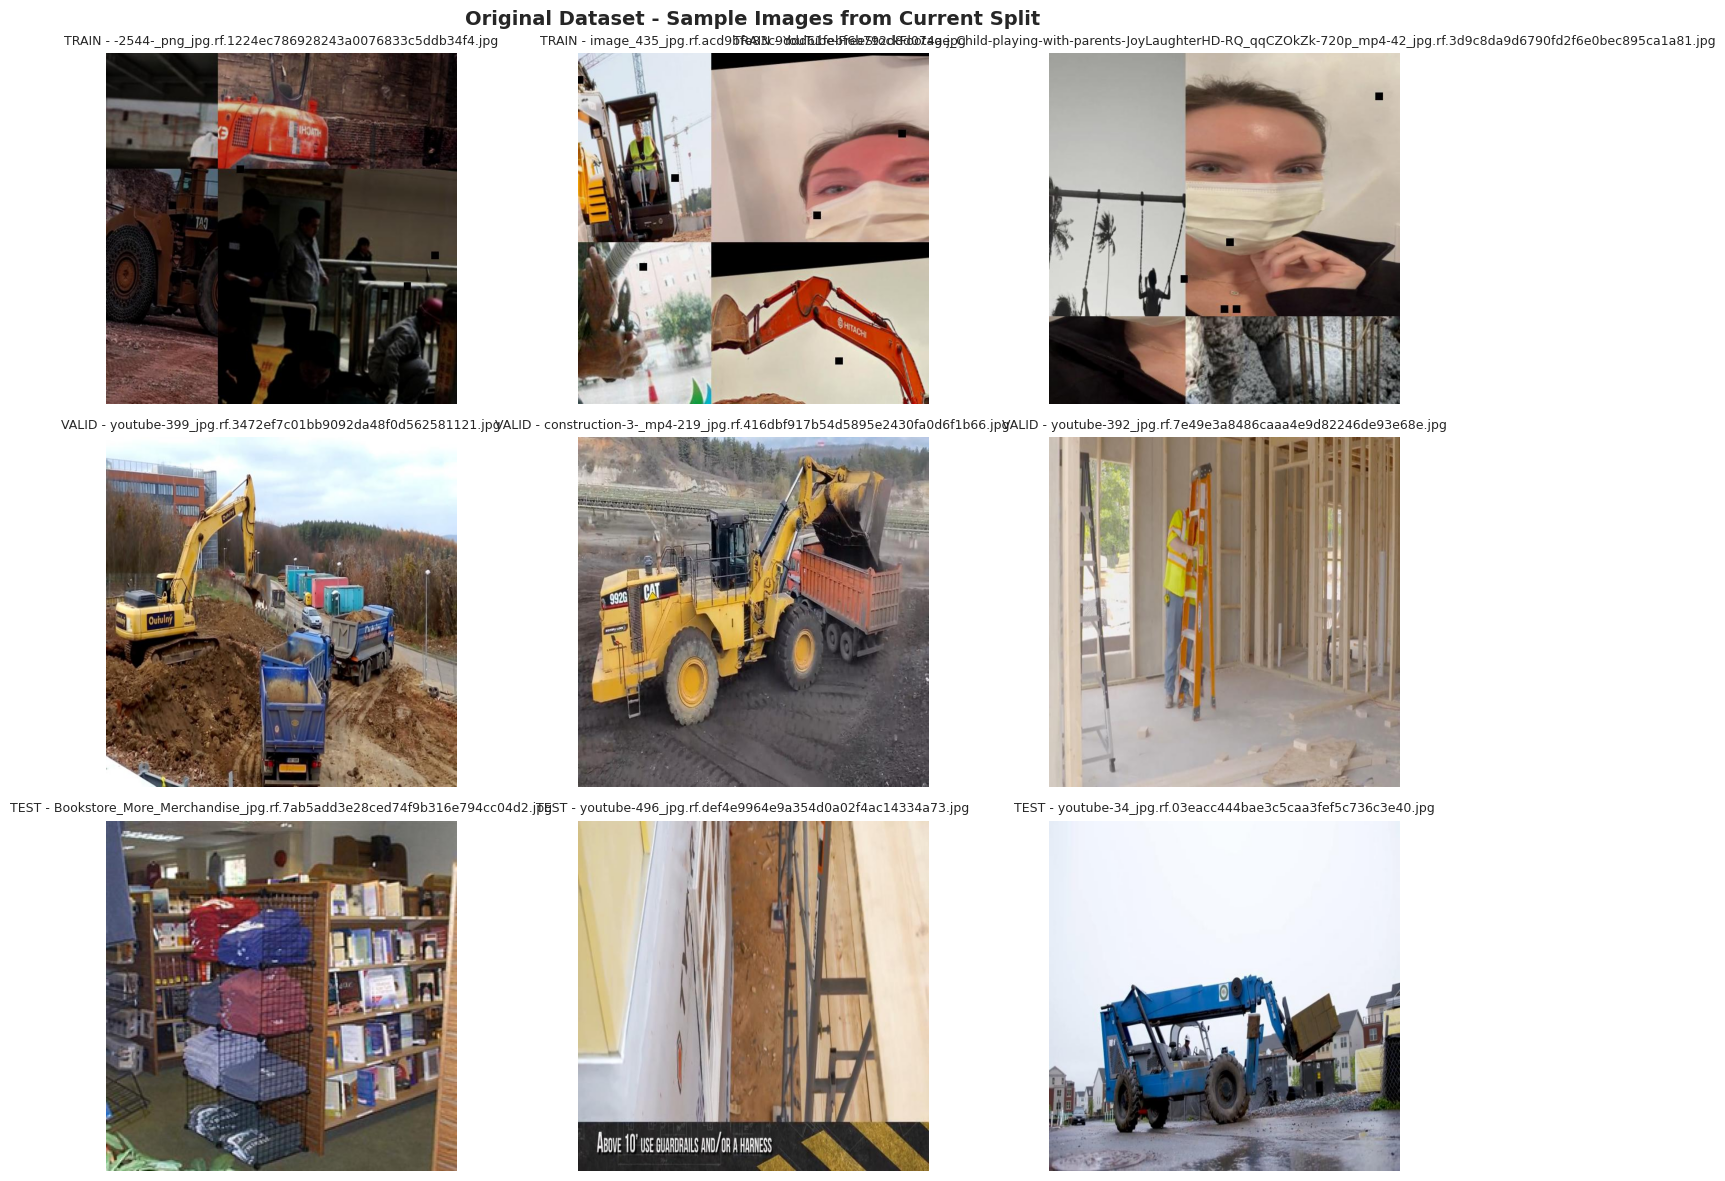

✓ Sample images visualized and saved as 'dataset_samples_original.png'


In [9]:
# Display sample images from current splits with annotations
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Original Dataset - Sample Images from Current Split', fontsize=14, fontweight='bold')

for idx, split in enumerate(['train', 'valid', 'test']):
    image_dir = data_root / split / 'images'
    image_files = list(image_dir.glob('*.jpg'))[:3]

    for jdx, img_file in enumerate(image_files):
        ax = axes[idx, jdx]
        img = cv2.imread(str(img_file))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(f'{split.upper()} - {img_file.name}', fontsize=9)
        ax.axis('off')

plt.tight_layout()
plt.savefig('dataset_samples_original.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Sample images visualized and saved as 'dataset_samples_original.png'")

## Stratified 70/15/15 Split

The original dataset split isn't balanced across classes. We're performing a stratified split to ensure each class is proportionally represented in train/val/test sets. This prevents the model from being biased toward overrepresented classes.

In [10]:
# Collect all images for stratified splitting
all_images = []
image_class_map = defaultdict(list)

for split in ['train', 'valid', 'test']:
    image_dir = data_root / split / 'images'
    ann_dir = annotations_root / split / 'labels'

    for img_file in image_dir.glob('*.jpg'):
        base_name = img_file.stem
        ann_file = ann_dir / f'{base_name}.txt'

        classes = parse_yolo_annotation(ann_file)
        primary_class = classes[0] if classes else 6

        all_images.append({
            'image_path': str(img_file),
            'annotation_path': str(ann_file),
            'primary_class': primary_class,
            'base_name': base_name
        })
        image_class_map[primary_class].append(len(all_images) - 1)

print(f"Total images collected: {len(all_images)}")

# Stratified split: 70% train, 15% val, 15% test
train_indices = []
temp_indices = []

for class_id in sorted(image_class_map.keys()):
    class_images = image_class_map[class_id]
    num_samples = len(class_images)

    num_train = int(num_samples * 0.70)
    num_val = int(num_samples * 0.15)

    random.shuffle(class_images)
    train_indices.extend(class_images[:num_train])
    temp_indices.extend(class_images[num_train:])

val_indices = temp_indices[:len(temp_indices)//2]
test_indices = temp_indices[len(temp_indices)//2:]

print(f"\nStratified Split:")
print("=" * 60)
print(f"Training:   {len(train_indices):4d} images ({len(train_indices)/len(all_images)*100:.1f}%)")
print(f"Validation: {len(val_indices):4d} images ({len(val_indices)/len(all_images)*100:.1f}%)")
print(f"Testing:    {len(test_indices):4d} images ({len(test_indices)/len(all_images)*100:.1f}%)")

Total images collected: 2801

Stratified Split:
Training:   1955 images (69.8%)
Validation:  423 images (15.1%)
Testing:     423 images (15.1%)


In [11]:
# Create new directory structure
resplit_root = Path('/content/drive/MyDrive/PPE_Project/dataset_resplit')
resplit_root.mkdir(exist_ok=True)

for split in ['train', 'val', 'test']:
    (resplit_root / 'images' / split).mkdir(parents=True, exist_ok=True)
    (resplit_root / 'labels' / split).mkdir(parents=True, exist_ok=True)

print("✓ Created directory structure")

# Copy files to new splits
def copy_files_to_split(indices, split_name):
    for idx in indices:
        img_info = all_images[idx]
        src_img = img_info['image_path']
        src_ann = img_info['annotation_path']

        dst_img = resplit_root / 'images' / split_name / Path(src_img).name
        dst_ann = resplit_root / 'labels' / split_name / Path(src_ann).name

        shutil.copy(src_img, dst_img)
        shutil.copy(src_ann, dst_ann)

print("\nCopying files...")
copy_files_to_split(train_indices, 'train')
print("  ✓ Training set")
copy_files_to_split(val_indices, 'val')
print("  ✓ Validation set")
copy_files_to_split(test_indices, 'test')
print("  ✓ Test set")

print("\n✓ Dataset resplit complete")

✓ Created directory structure

Copying files...
  ✓ Training set
  ✓ Validation set
  ✓ Test set

✓ Dataset resplit complete


## Verify Class Distribution

Checking that our stratified split maintained balanced class representation across all splits.

In [12]:
# Verify new class distribution is balanced
new_class_distribution = defaultdict(int)

for split in ['train', 'val', 'test']:
    ann_dir = resplit_root / 'labels' / split

    for ann_file in ann_dir.glob('*.txt'):
        with open(ann_file, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if parts:
                    class_id = int(parts[0])
                    new_class_distribution[class_id] += 1

print("New Class Distribution (All Splits Combined):")
print("=" * 60)
for cls_id in sorted(new_class_distribution.keys()):
    print(f"{ppe_classes[cls_id]:20s}: {new_class_distribution[cls_id]:5d} objects")

New Class Distribution (All Splits Combined):
Hardhat             :  3334 objects
NO-Hardhat          :  1700 objects
Safety Vest         :  2427 objects
NO-Safety Vest      :  3250 objects
Mask                :  4158 objects
NO-Mask             :  9872 objects
Person              :  3502 objects
Safety Cone         :  3135 objects
Machinery           :  5346 objects
Vehicle             :  1628 objects


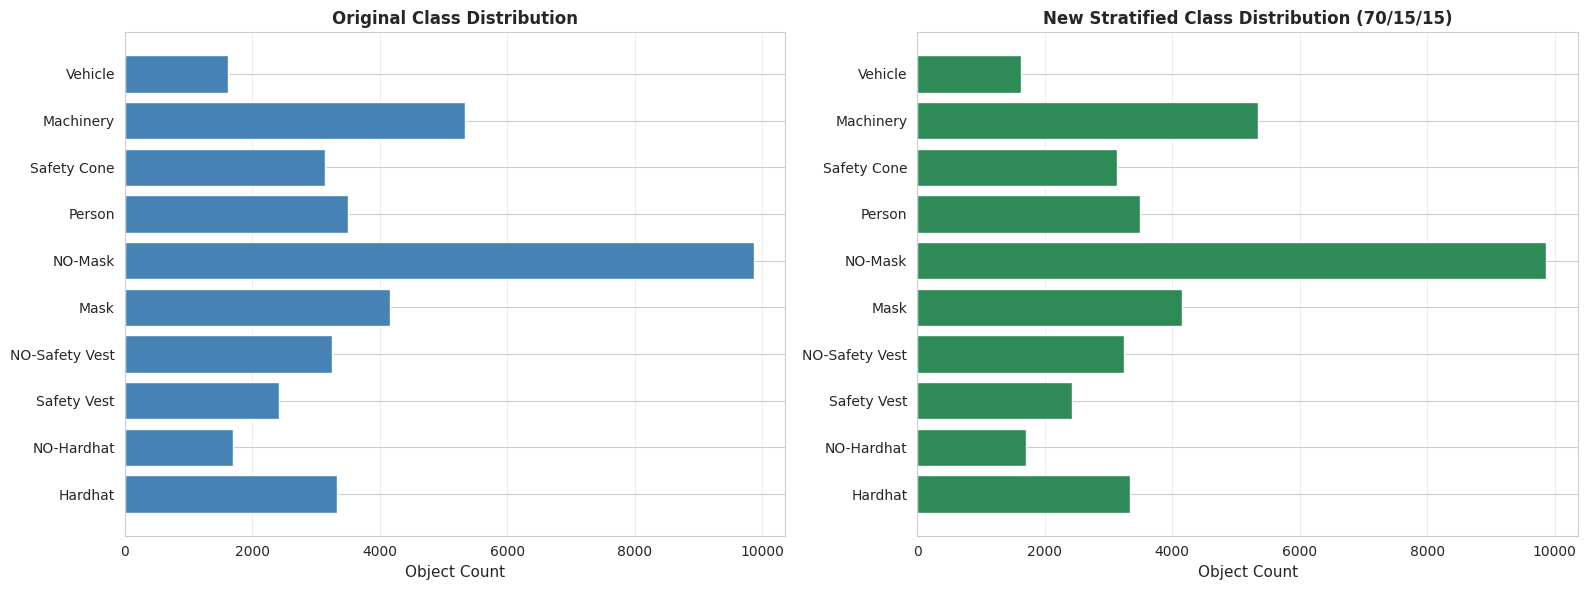

✓ Class distribution comparison visualized and saved as 'class_distribution_comparison.png'


In [13]:
# Visualize class distribution comparison before and after resplit
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_ids = sorted(class_distribution.keys())
class_names = [ppe_classes[cid] for cid in class_ids]
class_counts_orig = [class_distribution[cid] for cid in class_ids]
class_counts_new = [new_class_distribution[cid] for cid in class_ids]

axes[0].barh(class_names, class_counts_orig, color='steelblue')
axes[0].set_xlabel('Object Count', fontsize=11)
axes[0].set_title('Original Class Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(class_names, class_counts_new, color='seagreen')
axes[1].set_xlabel('Object Count', fontsize=11)
axes[1].set_title('New Stratified Class Distribution (70/15/15)', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('class_distribution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Class distribution comparison visualized and saved as 'class_distribution_comparison.png'")

## Image Dimensions Analysis

Understanding image dimensions helps us choose appropriate input sizes for the YOLO model and identify any outliers.

Image Dimension Statistics:
Width  - Mean:    640px, Std:      0px
         Range: [640, 640] px

Height - Mean:    640px, Std:      0px
         Range: [640, 640] px

File Size - Mean: 0.052MB, Max: 0.115MB


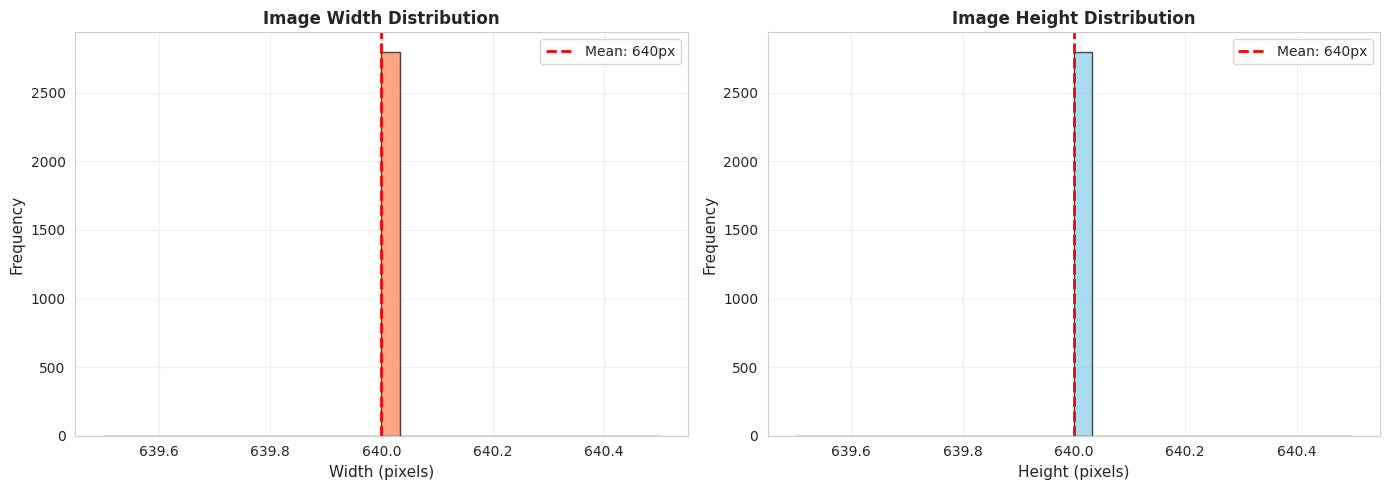


✓ Image dimension analysis complete and saved as 'image_dimensions.png'


In [14]:
# Analyze image properties across the resplit dataset
image_widths = []
image_heights = []
image_sizes_mb = []

for split in ['train', 'val', 'test']:
    image_dir = resplit_root / 'images' / split

    for img_file in image_dir.glob('*.jpg'):
        img = Image.open(img_file)
        w, h = img.size
        image_widths.append(w)
        image_heights.append(h)
        image_sizes_mb.append(os.path.getsize(img_file) / (1024*1024))

print(f"Image Dimension Statistics:")
print("=" * 60)
print(f"Width  - Mean: {np.mean(image_widths):6.0f}px, Std: {np.std(image_widths):6.0f}px")
print(f"         Range: [{np.min(image_widths):.0f}, {np.max(image_widths):.0f}] px")
print(f"\nHeight - Mean: {np.mean(image_heights):6.0f}px, Std: {np.std(image_heights):6.0f}px")
print(f"         Range: [{np.min(image_heights):.0f}, {np.max(image_heights):.0f}] px")
print(f"\nFile Size - Mean: {np.mean(image_sizes_mb):.3f}MB, Max: {np.max(image_sizes_mb):.3f}MB")

# Visualize dimension distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(image_widths, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Width (pixels)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Image Width Distribution', fontsize=12, fontweight='bold')
axes[0].axvline(np.mean(image_widths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(image_widths):.0f}px')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(image_heights, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Height (pixels)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Image Height Distribution', fontsize=12, fontweight='bold')
axes[1].axvline(np.mean(image_heights), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(image_heights):.0f}px')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('image_dimensions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Image dimension analysis complete and saved as 'image_dimensions.png'")

## Annotated Sample Visualization

Visualizing the bounding box annotations to verify they're correctly formatted and understand the annotation quality.

In [15]:
# Color scheme for each class
class_colors = {
    0: (255, 0, 0),      # Hardhat
    1: (0, 0, 255),      # NO-Hardhat
    2: (0, 255, 0),      # Safety Vest
    3: (255, 255, 0),    # NO-Safety Vest
    4: (255, 0, 255),    # Mask
    5: (128, 0, 128),    # NO-Mask
    6: (255, 128, 0),    # Person
    7: (0, 255, 255),    # Safety Cone
    8: (128, 128, 0),    # Machinery
    9: (0, 128, 128)     # Vehicle
}

def draw_annotations(image_path, annotation_path):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    with open(annotation_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center = float(parts[1]) * w
                y_center = float(parts[2]) * h
                box_w = float(parts[3]) * w
                box_h = float(parts[4]) * h

                x1 = int(x_center - box_w / 2)
                y1 = int(y_center - box_h / 2)
                x2 = int(x_center + box_w / 2)
                y2 = int(y_center + box_h / 2)

                color = class_colors.get(class_id, (255, 255, 255))
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(img, ppe_classes[class_id], (x1, y1 - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display samples
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle('Resplit Dataset - Annotated Samples', fontsize=14, fontweight='bold')

for split_idx, split in enumerate(['train', 'val', 'test']):
    image_dir = resplit_root / 'images' / split
    ann_dir = resplit_root / 'labels' / split

    image_files = sorted(list(image_dir.glob('*.jpg')))[:4]

    for col_idx, img_file in enumerate(image_files):
        base_name = img_file.stem
        ann_file = ann_dir / f'{base_name}.txt'

        annotated_img = draw_annotations(str(img_file), str(ann_file))

        ax = axes[split_idx, col_idx]
        ax.imshow(annotated_img)
        ax.set_title(f'{split.upper()} - {base_name}', fontsize=8)
        ax.axis('off')

plt.tight_layout()
plt.savefig('annotated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Annotated samples saved")

Output hidden; open in https://colab.research.google.com to view.

## Create YAML Configuration

YOLOv8 requires a YAML file that specifies dataset paths and class mappings. This will be used during model training.

In [16]:
# Create YAML file for YOLOv8
yaml_content = f"""path: /content/drive/MyDrive/PPE_Project/dataset_resplit
train: images/train
val: images/val
test: images/test

nc: 10
names:
  0: Hardhat
  1: NO-Hardhat
  2: Safety Vest
  3: NO-Safety Vest
  4: Mask
  5: NO-Mask
  6: Person
  7: Safety Cone
  8: Machinery
  9: Vehicle
"""

with open('/content/drive/MyDrive/PPE_Project/dataset.yaml', 'w') as f:
    f.write(yaml_content)

print("✓ dataset.yaml created in Google Drive")
print("\n" + yaml_content)

✓ dataset.yaml created in Google Drive

path: /content/drive/MyDrive/PPE_Project/dataset_resplit
train: images/train
val: images/val
test: images/test

nc: 10
names:
  0: Hardhat
  1: NO-Hardhat
  2: Safety Vest
  3: NO-Safety Vest
  4: Mask
  5: NO-Mask
  6: Person
  7: Safety Cone
  8: Machinery
  9: Vehicle



## Summary

Final statistics on our processed dataset ready for model training.

In [17]:
# Dataset summary
summary_data = {
    'Total Images': [len(train_indices), len(val_indices), len(test_indices),
                     len(train_indices) + len(val_indices) + len(test_indices)],
    'Percentage': [f"{len(train_indices)/len(all_images)*100:.1f}%",
                   f"{len(val_indices)/len(all_images)*100:.1f}%",
                   f"{len(test_indices)/len(all_images)*100:.1f}%",
                   "100%"]
}

summary_df = pd.DataFrame(summary_data, index=['Train', 'Validation', 'Test', 'Total'])
print("\nDataset Split Summary:")
print("=" * 60)
print(summary_df)

print(f"\nTotal PPE Objects: {sum(new_class_distribution.values())}")
print(f"Number of Classes: {len(new_class_distribution)}")
print(f"Average Objects per Image: {sum(new_class_distribution.values()) / len(all_images):.2f}")

print("\n" + "="*60)
print("DATA EXPLORATION COMPLETE")
print("="*60)


Dataset Split Summary:
            Total Images Percentage
Train               1955      69.8%
Validation           423      15.1%
Test                 423      15.1%
Total               2801       100%

Total PPE Objects: 38352
Number of Classes: 10
Average Objects per Image: 13.69

DATA EXPLORATION COMPLETE
